In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import PoissonRegressor, LogisticRegression
import sklearn.manifold as manifold
from sklearn.model_selection import cross_val_score
from jupyterthemes import jtplot ; jtplot.style()
from os import chdir
chdir('/Users/albertwakhloo/Desktop/models/neuromatch/steinmetz')
#import vapeplot

In [2]:
data_fname1 = 'steinmetz_NMA_part1.npz'
data_fname2 = 'steinmetz_NMA_part2.npz'
alldat = np.load('steinmetz_NMA_part1.npz', allow_pickle=True)['dat']
alldat = np.hstack((alldat, np.load('steinmetz_NMA_part2.npz', allow_pickle=True)['dat']))
#alldat.to_csv('compiled_subset.csv')
dat = alldat[11]

In [3]:
regions = ["vis ctx", "thal", "hipp", "other ctx", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
               ]

NN = len(dat['brain_area']) # number of neurons
barea = len(brain_groups) * np.ones(NN, ) # last one is "other"
for j in range(len(brain_groups)):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number of each region to each neuron
    #can be used to pull out neurons wrt larger region

for i, d in enumerate(alldat) : 
    np.savetxt(f"maus{i}.csv", d, delimiter=",")

In [4]:
spks = alldat[11]['spks']

In [5]:
dat['brain_area'][spks[barea == 0, :, 0]] #doesn't work for indexing, as this just pulls out the actual spks
#array

array([['VISp', 'VISp', 'VISp', ..., 'VISp', 'VISp', 'VISp'],
       ['VISp', 'VISp', 'VISp', ..., 'VISp', 'VISp', 'VISp'],
       ['VISp', 'VISp', 'VISp', ..., 'VISp', 'VISp', 'VISp'],
       ...,
       ['VISp', 'VISp', 'VISp', ..., 'VISp', 'VISp', 'VISp'],
       ['VISp', 'VISp', 'VISp', ..., 'VISp', 'VISp', 'VISp'],
       ['VISp', 'VISp', 'VISp', ..., 'VISp', 'VISp', 'VISp']], dtype='<U5')

In [6]:
dat.keys()

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp'])

In [7]:
np.unique(dat['brain_area'][spks[barea == 0, :, 0 ]])

array(['DG', 'SUB', 'VISp'], dtype='<U5')

neurons x trial x time bin

In [8]:
area = 0
v1 = spks[barea == area, :, :]
print(v1.shape)
trialxtime = v1.shape[1] * v1.shape[2]
neurons = v1.shape[0]
v1 = v1.reshape((neurons, trialxtime)) #np.concatenate(v1, axis = 1)
v1.shape

(144, 340, 250)


(144, 85000)

In [9]:
df = pd.DataFrame(v1.T, columns = [f"n_{i}" for i in range(1, neurons + 1)]) #, columns = ['neuron', 'time_bin{}'])
trials = 340
bins = 250
df['time'] = np.array(list(np.arange(bins)) * trials) 
df['time'] = df['time'].values * 0.01
df['stim'] = np.zeros(df.shape[0])
df.loc[df.time == 0.5, 'stim'] = 1 
df['trial'] = np.array([np.repeat(trial, bins) for trial in range(trials)]).flatten()
print(df.columns[-5:])
df.shape

Index(['n_143', 'n_144', 'time', 'stim', 'trial'], dtype='object')


(85000, 147)

# build a decoding model: one way to expand  this is to build the df out stimulus intensities. another way is to time lag the stimulus!! 

In [10]:
def time_lag_stim(stim, d = 25) : 
    return np.pad(stim, (0, d))[d:]

training predictive score = 0.996
test predictive score = 0.996


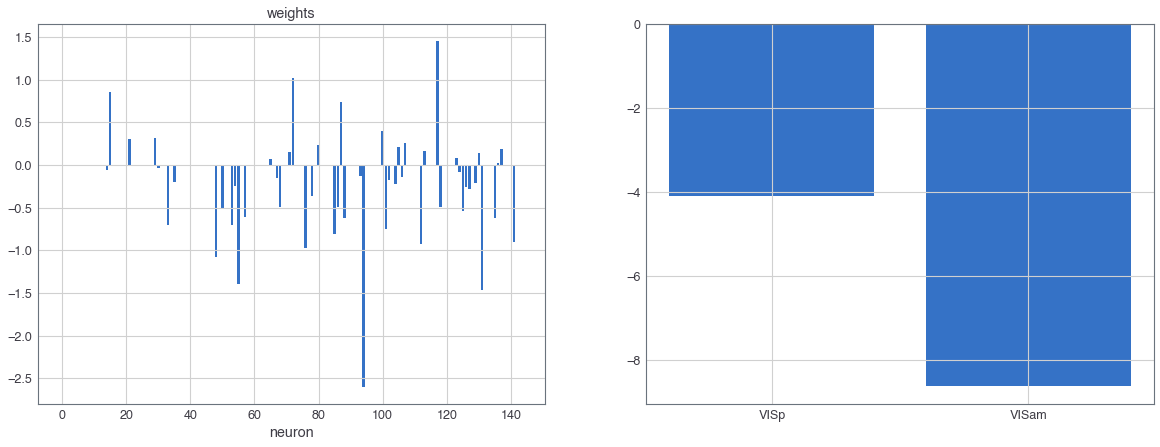

In [11]:
truncate = 70000
neuron_m = df.loc[:, 'n_1' : f'n_{neurons}'].values[:truncate]
stim = df.stim.values[:truncate]
stim = time_lag_stim(stim, d = 25)

#model = LogisticRegression(penalty = 'l2') for L2 regularization
model = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter = 5000)
labels = dat['brain_area'][barea == area]
decoder = model.fit(neuron_m, stim)
coefficients = decoder.coef_.reshape(neuron_m.shape[1])
print('training predictive score = ' +str(decoder.score(neuron_m, stim)))

#test dat
test_neuron = df.loc[:, 'n_1' : f'n_{neurons}'].values[truncate:]
test_stim = df.stim.values[truncate:] 
pred = decoder.predict(test_neuron)
pred_acc = (test_stim == pred).mean() 
print('test predictive score = ' + str(pred_acc))
#scores = cross_val_score(LogisticRegression(penalty = 'l2'), neuron_m, stim, cv = 5)
#print(f'k-fold cross validation score = ' + str(scores))


_, ax = plt.subplots(1, 2, figsize = (20, 7))
ax[0].bar(np.arange(neurons), coefficients)
ax[0].set_title('weights')
ax[0].set_xlabel('neuron')

area_coeff = np.array([np.sum(coefficients[labels == j]) for j in labels])
ax[1].bar(labels, area_coeff)


plt.show()

pick out a neuron to construct a decoding model for : 

In [12]:
np.argwhere(coefficients < -1)
#coefficients[100] # we'll see if this one works

array([[ 48],
       [ 55],
       [ 94],
       [131]])

# build a time lag design matrix based on stim times 

In [13]:
def time_lag_matrix(stim, d = 25) : 
    stim = stim.flatten() 
    stim_v = np.concatenate((np.zeros(d - 1), stim)) #pad 24 zeros before the first trial. now we have a workable stim vector
    T = len(stim) 
    M = np.zeros((T, d)) 
    for t in range(T) : 
        M[t] = stim_v[t: t + d] #e.g. when t = 0 we pull out the 24 pads plus the first '0' point
    return M 

train fit = 2.660487520955712e-06
test fit = -0.0014412623413850856
test fit 2 = 0.0


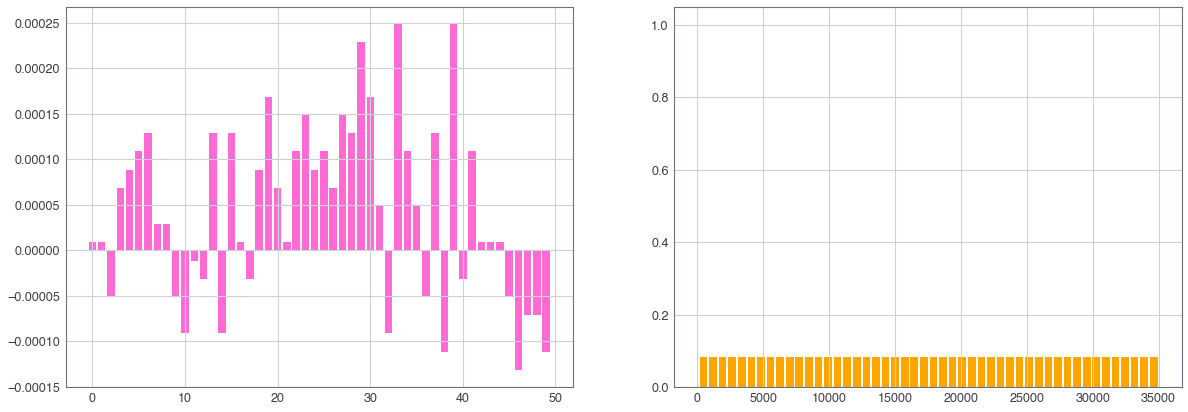

In [67]:
truncate = 50000
lag = 50
n = 94

neur = f'n_{n}'
nu = df[neur].values[:truncate]
stim = df.stim.values[:truncate]
M = time_lag_matrix(stim, d = lag) 
encode = PoissonRegressor()
encoder = encode.fit(M, nu)

test_nu = df.n_94[truncate:]
test_stim = df.stim.values[truncate:]
test_M = time_lag_matrix(test_stim, d = lag)
pred = encoder.predict(test_M)
print('train fit = ' + str(encoder.score(M, nu)))
print('test fit = ' + str(encoder.score(test_M, test_nu)))
print('pct correct = ' + str((pred == test_stim).mean()))


_, ax = plt.subplots(1, 2, figsize = (20, 7))
ax[0].bar(np.arange(lag), encoder.coef_)

ax[1].bar(np.arange(len(test_stim)), test_stim, color = 'blue')
ax[1].bar(np.arange(len(test_stim)), pred, color = 'orange')

plt.show()

# manifoldsssss~~~~

In [70]:
#sett = df.loc[:, 'n_1' : f'n_{neurons}'].values[:5000]
neu = dat['spks'].reshape((697, 340 * 250))[:20000]
fold = manifold.TSNE(n_components = 2, perplexity = 50).fit_transform(neu)

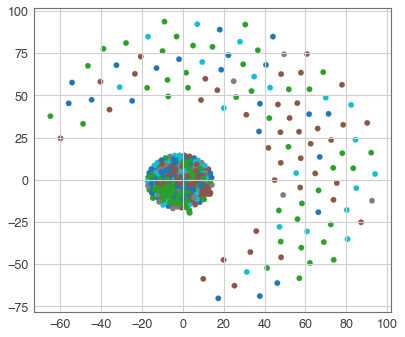

In [71]:
plt.scatter(fold[:, 0], fold[:, 1], c= barea, cmap = 'tab10')

In [68]:
spks.shape

(697, 340, 250)